# Testing
### Neubautätigkeit nach Bauprojektstatus und Stadtquartier seit 2009
Datum: 03.02.2022

### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [2]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [3]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [4]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [5]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 2 datenstand:  0 time.struct_time(tm_year=2022, tm_mon=2, tm_mday=3, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=34, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [6]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011

In [33]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int";
print(status)

int


In [34]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
else:
    fp = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_OD5011\BAU501OD5011.csv"   

print(fp)

\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_OD5011\BAU501OD5011.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [35]:
# Read the data
data2betested = pd.read_csv(
    fp
    , sep=','
    ,parse_dates=['Jahr']
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
    ,low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [36]:
#data2betested.head(6)

In [37]:
data2betested.dtypes

Jahr              datetime64[ns]
QuarSort                   int64
QuarLang                  object
KreisSort                  int64
KreisLang                 object
ProjStatus                object
ProjAnzGbd                 int64
ProjKosten                 int64
ProjRauminhalt             int64
ProjAnzWhg                 int64
Whg_1_3_Zi                 int64
Whg_4plus_Zi               int64
dtype: object

In [38]:
data2betested.shape

(1119, 12)

Beschreibe einzelne Attribute

In [39]:
data2betested.describe()

,QuarSort,KreisSort,ProjAnzGbd,ProjKosten,ProjRauminhalt,ProjAnzWhg,Whg_1_3_Zi,Whg_4plus_Zi
count,1119,1119,1119,1119,1119,1119,1119,1119
mean,70,7,20,91606,134488,133,91,43
std,34,3,26,134848,187792,195,137,67
min,11,1,0,0,20,0,0,0
25%,41,4,4,0,22326,18,11,4
50%,72,7,11,43160,63920,60,39,17
75%,101,10,25,116045,161404,165,113,52
max,123,12,243,938000,1899504,1659,1195,561


Wie viele Nullwerte gibt es im Datensatz?

In [40]:
data2betested.isnull().sum()

Jahr              0
QuarSort          0
QuarLang          0
KreisSort         0
KreisLang         0
ProjStatus        0
ProjAnzGbd        0
ProjKosten        0
ProjRauminhalt    0
ProjAnzWhg        0
Whg_1_3_Zi        0
Whg_4plus_Zi      0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [41]:
data2betested = data2betested.set_index("Jahr")

In [42]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1119 entries, 2009-01-01 to 2021-01-01
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   QuarSort        1119 non-null   int64 
 1   QuarLang        1119 non-null   object
 2   KreisSort       1119 non-null   int64 
 3   KreisLang       1119 non-null   object
 4   ProjStatus      1119 non-null   object
 5   ProjAnzGbd      1119 non-null   int64 
 6   ProjKosten      1119 non-null   int64 
 7   ProjRauminhalt  1119 non-null   int64 
 8   ProjAnzWhg      1119 non-null   int64 
 9   Whg_1_3_Zi      1119 non-null   int64 
 10  Whg_4plus_Zi    1119 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 104.9+ KB


Int64Index([1], dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [43]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [45]:
data2betested.loc["2009"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,QuarSort,QuarLang,KreisSort,KreisLang,ProjStatus,ProjAnzGbd,ProjKosten,ProjRauminhalt,ProjAnzWhg,Whg_1_3_Zi,Whg_4plus_Zi
Jahr,,,,,,,,,,,
2009-01-01,11,Rathaus,1,Kreis 1,Fertigerstellt,1,0,1365,3,3,0
2009-01-01,11,Rathaus,1,Kreis 1,Im Bau,2,0,17690,0,0,0


### Visualisierungen nach Zeitausschnitten

#### Entwicklung projektierter Gebäude und Wohnungen nach Projektstatus

In [61]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1996":"2021"]\
    .groupby(['Jahr','ProjStatus']) \
    .agg(sum_ProjAnzGbd=('ProjAnzGbd', 'sum'),sum_ProjAnzWhg=('ProjAnzWhg', 'sum')) \
    .sort_values('Jahr', ascending=True) 

myAgg.reset_index().head(3)

,Jahr,ProjStatus,sum_ProjAnzGbd,sum_ProjAnzWhg
0,2009-01-01,Bewilligt,368,2903
1,2009-01-01,Fertigerstellt,169,1381
2,2009-01-01,Im Bau,434,4176


In [62]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['ProjStatus'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_ProjAnzGbd > 1'), title="Title").encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_ProjAnzGbd', axis=alt.Axis(title='Anz. Projektierte Gebäude'))
    , color=alt.Color('ProjStatus', legend=alt.Legend(title="Projektstatus", orient="right"))  
    ,tooltip=['Jahr', 'ProjStatus','sum_ProjAnzGbd', 'sum_ProjAnzWhg']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung fertigerstellter Projekte nach Stadtkreis

In [72]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1996":"2021"].query('ProjStatus == "Fertigerstellt"')\
    .groupby(['Jahr','KreisLang']) \
    .agg(sum_ProjAnzGbd=('ProjAnzGbd', 'sum'),sum_ProjAnzWhg=('ProjAnzWhg', 'sum')) \
    .sort_values('Jahr', ascending=True) 

myAgg.reset_index().head(3)

,Jahr,KreisLang,sum_ProjAnzGbd,sum_ProjAnzWhg
0,2009-01-01,Kreis 1,1,3
1,2009-01-01,Kreis 9,24,243
2,2009-01-01,Kreis 8,10,111


In [73]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['KreisLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index(), title="Title").encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_ProjAnzGbd', axis=alt.Axis(title='Anz. Projektierte Gebäude'))
    , color=alt.Color('KreisLang', legend=alt.Legend(title="Stadtkreis", orient="right"))  
    ,tooltip=['Jahr', 'KreisLang','sum_ProjAnzGbd', 'sum_ProjAnzWhg']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [78]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2021"]\
    .groupby(['Jahr', 'KreisLang', 'ProjStatus']) \
    .agg(sum_ProjAnzGbd=('ProjAnzGbd', 'sum'),sum_ProjAnzWhg=('ProjAnzWhg', 'sum')) \
    .sort_values('Jahr', ascending=True) 

myAggBar.reset_index().head(3)

,Jahr,KreisLang,ProjStatus,sum_ProjAnzGbd,sum_ProjAnzWhg
0,2021-01-01,Kreis 1,Fertigerstellt,0,0
1,2021-01-01,Kreis 9,Bewilligt,74,602
2,2021-01-01,Kreis 8,Im Bau,37,98


In [314]:
#help(sns.catplot)     

In [315]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

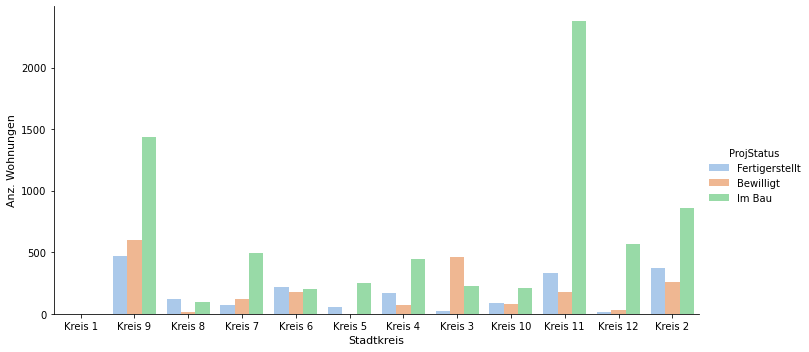

In [81]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="KreisLang"
            , y="sum_ProjAnzWhg"
            , hue="ProjStatus"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xlabels('Stadtkreis', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Wohnungen', fontsize=11)


In [96]:
#data2betested.dtypes

In [93]:
myAggBar = data2betested.loc["2000":"2021"]\
    .groupby(['Jahr', 'QuarLang', 'ProjStatus']) \
    .agg(sum_ProjAnzGbd=('ProjAnzGbd', 'sum'),sum_ProjAnzWhg=('ProjAnzWhg', 'sum')) \
    .sort_values('Jahr', ascending=True) 

In [94]:
#myAggBar.reset_index()

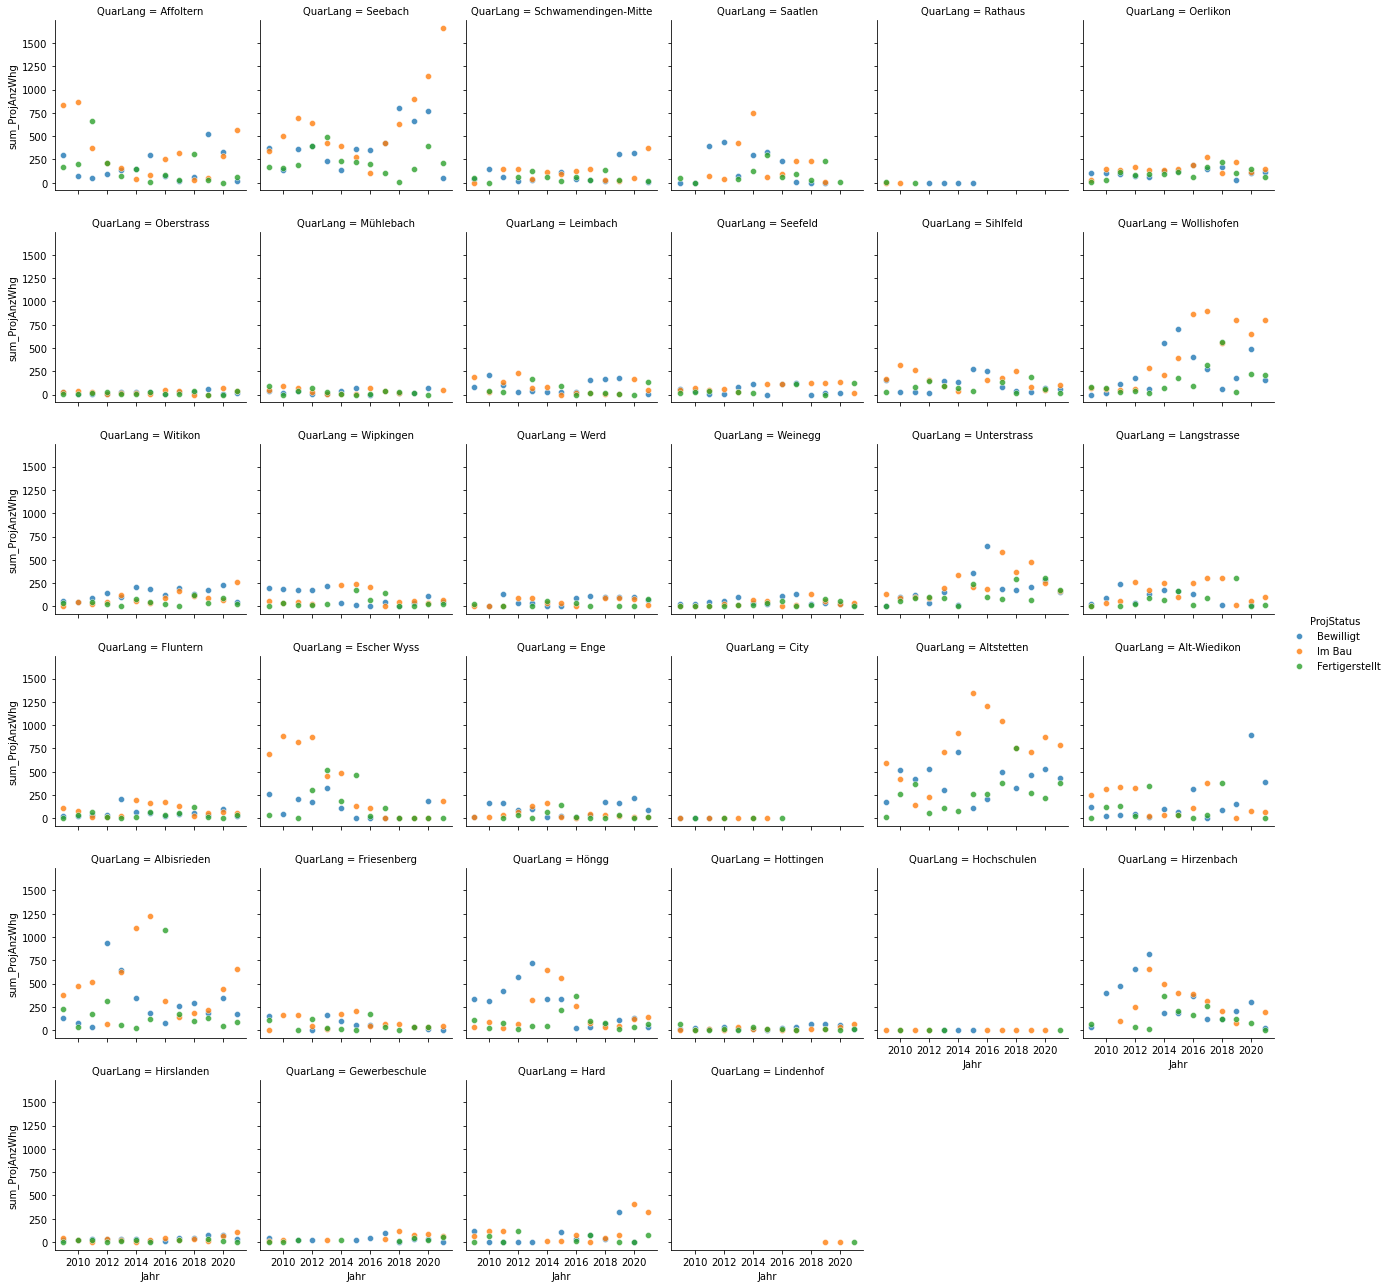

In [95]:
g = sns.FacetGrid(myAggBar.reset_index(), col="QuarLang", hue="ProjStatus", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_ProjAnzWhg", alpha=.8)
g.map(sns.lineplot, "Jahr","sum_ProjAnzWhg",alpha=.8)

g.add_legend()

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Anzahl Wohnungen in BAUPROJEKTEN nach Projektstatus, Kreis und Quartier 2021

In [107]:
data2betested.dtypes

QuarSort           int64
QuarLang          object
KreisSort          int64
KreisLang         object
ProjStatus        object
ProjAnzGbd         int64
ProjKosten         int64
ProjRauminhalt     int64
ProjAnzWhg         int64
Whg_1_3_Zi         int64
Whg_4plus_Zi       int64
dtype: object

In [108]:
myTreemapAgg = data2betested.loc["2021"]  \
    .groupby(['Jahr', 'QuarLang', 'KreisLang', 'ProjStatus']) \
    .agg(sum_ProjAnzGbd=('ProjAnzGbd', 'sum'),sum_ProjAnzWhg=('ProjAnzWhg', 'sum'))\
    .sort_values('sum_ProjAnzWhg', ascending=False) 

myTreemapAgg.reset_index().head(3)

,Jahr,QuarLang,KreisLang,ProjStatus,sum_ProjAnzGbd,sum_ProjAnzWhg
0,2021-01-01,Seebach,Kreis 11,Im Bau,184,1659
1,2021-01-01,Wollishofen,Kreis 2,Im Bau,63,796
2,2021-01-01,Altstetten,Kreis 9,Im Bau,113,782


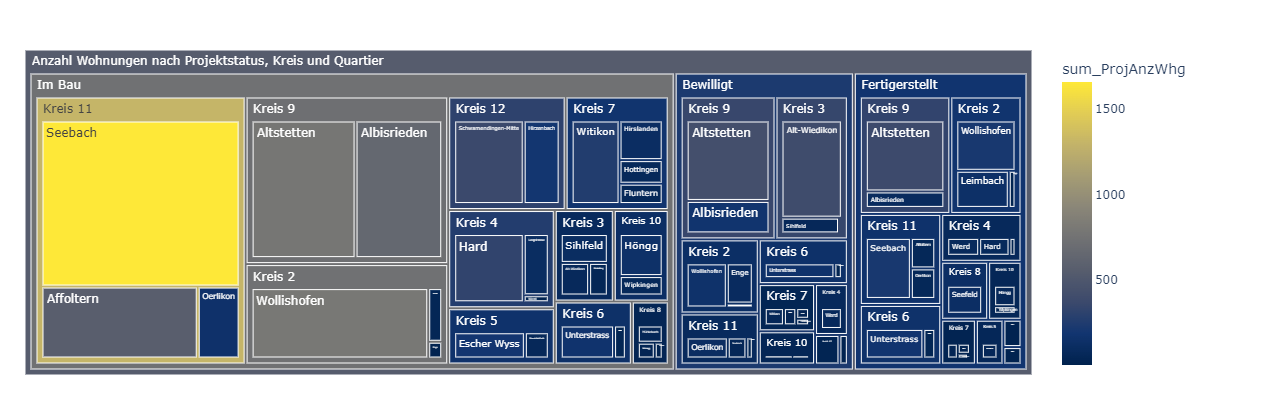

In [112]:
fig = px.treemap(myTreemapAgg.query('sum_ProjAnzWhg >0').reset_index(), path=[px.Constant("Anzahl Wohnungen nach Projektstatus, Kreis und Quartier"),'ProjStatus', 'KreisLang', 'QuarLang']
                 , values='sum_ProjAnzWhg'
                 , color='sum_ProjAnzWhg'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

#### Anzahl Wohnungen nach Projektstatus, Kreis und Quartier

In [113]:
data2betested.dtypes

QuarSort           int64
QuarLang          object
KreisSort          int64
KreisLang         object
ProjStatus        object
ProjAnzGbd         int64
ProjKosten         int64
ProjRauminhalt     int64
ProjAnzWhg         int64
Whg_1_3_Zi         int64
Whg_4plus_Zi       int64
dtype: object

In [123]:
myTreemapAgg = data2betested.loc["2021"]  \
    .groupby(['Jahr', 'QuarLang', 'KreisLang', 'ProjStatus']) \
    .agg(sum_ProjKosten=('ProjKosten', 'sum'), sum_Whg_1_3_Zi=('Whg_1_3_Zi', 'sum'),sum_Whg_4plus_Zi=('Whg_4plus_Zi', 'sum'))\
    .sort_values('sum_Whg_1_3_Zi', ascending=False) 

myTreemapAgg.reset_index().head(3)

,Jahr,QuarLang,KreisLang,ProjStatus,sum_ProjKosten,sum_Whg_1_3_Zi,sum_Whg_4plus_Zi
0,2021-01-01,Seebach,Kreis 11,Im Bau,867143,1098,561
1,2021-01-01,Wollishofen,Kreis 2,Im Bau,320688,611,185
2,2021-01-01,Altstetten,Kreis 9,Im Bau,593275,601,181


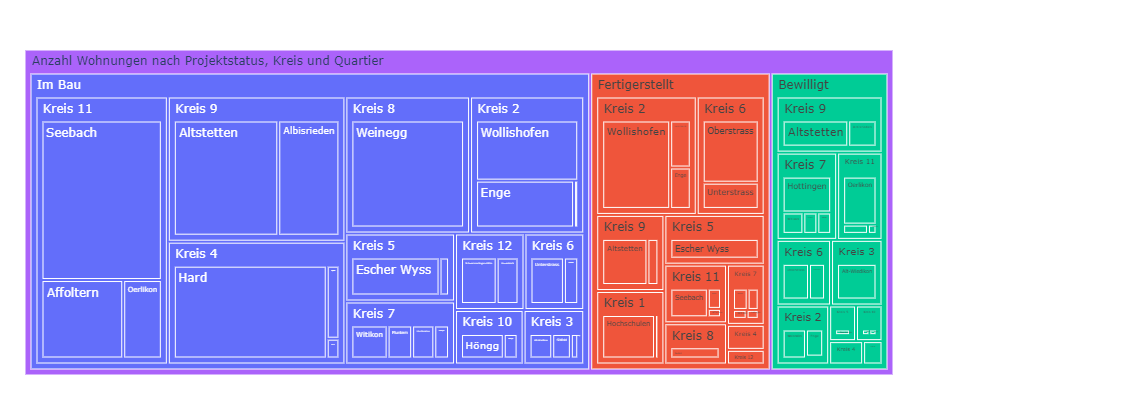

In [125]:
fig = px.treemap(myTreemapAgg.query('sum_ProjKosten >0').reset_index(), path=[px.Constant("Anzahl Wohnungen nach Projektstatus, Kreis und Quartier"),'ProjStatus', 'KreisLang', 'QuarLang']
                 , values='sum_ProjKosten'
                 , color='ProjStatus'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [117]:
#data2betested.dtypes

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=140&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

In [153]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Wenn die Daten lokal agelegt sind, dann kannst Du folgendes machen:
##input_stadtquartiere = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/stzh.adm_statistische_quartiere_map.json"
##df_stadtquartiere = gpd.read_file(input_stadtquartiere)
##df_stadtquartiere.head(2)
#df_stadtkreise.dtypes

geojson_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url)

df_adm_statistische_quartiere_map.head(5)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."
2,adm_statistische_quartiere_map.3,Kreis 8,8,3,32,Mühlebach,82,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ..."
3,adm_statistische_quartiere_map.4,Kreis 8,8,4,31,Seefeld,81,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ..."
4,adm_statistische_quartiere_map.7,Kreis 4,4,7,16,Werd,41,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [154]:
akt_wbev_quart = data2betested.loc["2021-11"].groupby(
    ['StichtagDatJahr','StichtagDatMM','QuarCd','QuarLang']
).agg(
    {'AnzBestWir':'sum'}
)
akt_wbev_quart.head()


AnzBestWir
StichtagDatJahr StichtagDatMM QuarCd QuarLang               
2021            11            11     Rathaus            3283
                              12     Hochschulen         718
                              13     Lindenhof          1033
                              14     City                835
                              21     Wollishofen       20002

In [158]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
stadtquartiere_shapes = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(akt_wbev_quart, on='QuarCd')

stadtquartiere_shapes_joined.head(2)


,geometry,QuarCd,qname,knr,AnzBestWir
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,7342
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,5564


<AxesSubplot:>

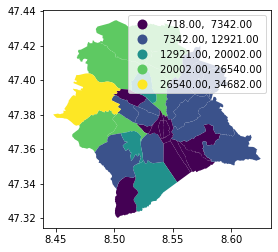

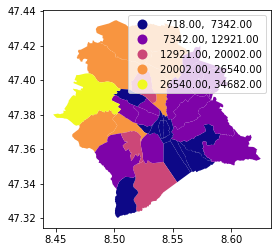

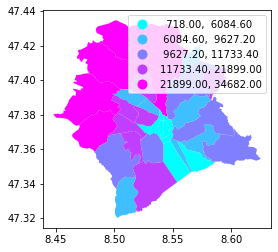

In [159]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='plasma', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html